## Imports

In [2]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np

from dataset import MultiModalDataset

## Function for saving videos

In [3]:
"""Function to save videos in ./outputs.

Args:
    video_tensor (Tensor): The video tensor in BNCTHW format.
    index (int): The video index in the batch. Default: 0.
"""
def output_video(video_tensor, index=0):
    os.makedirs('output', exist_ok=True)
    for i, np_image in enumerate(video_tensor[index].squeeze().permute(1,2,3,0)):
        print(np_image.shape)
        img_array = np.array(np_image.numpy())
        plt.imshow(img_array)
        plt.axis('off')  # Turn off axis labels and ticks

        # Save the image using plt.savefig()
        output_path = f"output/{i}.jpg"
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=300)

## Loading batches

In [4]:
dataset = MultiModalDataset(ann_file='../../data/something-something-v2/train_annotations.txt',
                            root_dir='../../data/something-something-v2/rawframes',
                            clip_len=32,
                            resolution=(240, 427),
                            modalities=('rgb'),
                            test_mode=False,
                            frame_interval=1,
                            input_resolution=(240, 427),
                            num_clips=1
                            )

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=dataset,
                                                batch_size=4,
                                                shuffle=True,
                                                num_workers=4,
                                                pin_memory=True)

In [6]:
iter_ = iter(train_loader)

In [7]:
result = next(iter_)
imgs = result['rgb'].unsqueeze(dim=1)
label = result['label'].unsqueeze(dim=1)
imgs.shape

torch.Size([3, 1, 3, 32, 240, 427])

In [8]:
original = imgs.clone()

torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])


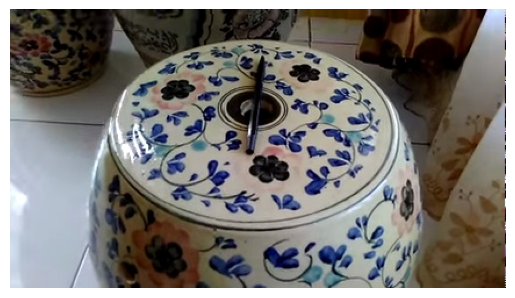

In [9]:
output_video(original, 1)

In [19]:
mixed_label

tensor([[74.7510],
        [77.1713],
        [46.8854],
        [55.1924]])

## Cutmix Output

torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])
torch.Size([240, 427, 3])


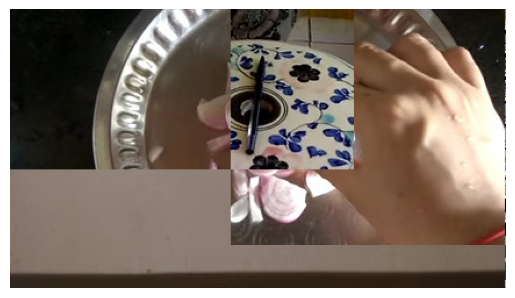

In [12]:
from methods import Scrambmix

mixup = Scrambmix(num_classes=100, num_frames=32, alpha=0.1)

mixed_imgs, mixed_label = mixup.do_blending(imgs, label)
output_video(mixed_imgs, 0)

## Scrambmix v3

In [83]:
from scipy import stats

class Scrambmixv3():
    """Implementing Scrambmix in a mini-batch.

    Args:
        num_classes (int): The number of classes.
        num_frames (int): The number of frames.
        alpha (float): Parameters for Beta Binomial distribution.
    """

    def __init__(self, num_classes, num_frames, alpha=5):
        self.num_frames = num_frames
        self.beta_binom = stats.betabinom(num_frames-1, alpha, alpha, loc=0)
        
    def rand_bbox(self, img_size, lam):
        """Generate a random boudning box."""
        w = img_size[-1]
        h = img_size[-2]
        cut_rat = torch.sqrt(1. - lam)
        cut_w = torch.tensor(int(w * cut_rat))
        cut_h = torch.tensor(int(h * cut_rat))

        # This is uniform
        cx = torch.randint(w, (1, ))[0]
        cy = torch.randint(h, (1, ))[0]

        bbx1 = torch.clamp(cx - cut_w // 2, 0, w)
        bby1 = torch.clamp(cy - cut_h // 2, 0, h)
        bbx2 = torch.clamp(cx + cut_w // 2, 0, w)
        bby2 = torch.clamp(cy + cut_h // 2, 0, h)

        return bbx1, bby1, bbx2, bby2

    def do_blending(self, imgs, label, **kwargs):
        """Blending images with scrambmix."""

        assert len(kwargs) == 0, f'unexpected kwargs for mixup {kwargs}'

        batch_size = imgs.size(0)
        
        epsilon = self.beta_binom.rvs() + 1
        interval = round(self.num_frames/epsilon)
        lam = torch.tensor(1/interval)
        rand_index = torch.randperm(batch_size)

        mask = torch.arange(self.num_frames) % interval == 0
        bbx1, bby1, bbx2, bby2 = self.rand_bbox(imgs.size(), lam)

        A = imgs
        B = A.clone()[rand_index, ...]
        
        # Apply the masks
        A[..., ~mask, bby1:bby2, bbx1:bbx2], B[..., mask, bby1:bby2, bbx1:bbx2] = B[..., ~mask, bby1:bby2, bbx1:bbx2], A[..., mask, bby1:bby2, bbx1:bbx2]
        
        A[..., mask, :, :] = 0
        B[..., ~mask, :, :] = 0
        
        # MixUp the frames and encodings
        mixed_imgs = A + B
        mixed_label = (1 - lam) * label +  lam * label[rand_index, :]

        return mixed_imgs, mixed_label

## Testing

In [126]:
def rand_bbox(img_size, lam):
    """Generate a random boudning box."""
    w = img_size[-1]
    h = img_size[-2]
    cut_rat = torch.sqrt(1. - lam)
    cut_w = torch.tensor(int(w * cut_rat))
    cut_h = torch.tensor(int(h * cut_rat))

    # This is uniform
    cx = torch.randint(w, (1, ))[0]
    cy = torch.randint(h, (1, ))[0]

    bbx1 = torch.clamp(cx - cut_w // 2, 0, w)
    bby1 = torch.clamp(cy - cut_h // 2, 0, h)
    bbx2 = torch.clamp(cx + cut_w // 2, 0, w)
    bby2 = torch.clamp(cy + cut_h // 2, 0, h)

    return bbx1, bby1, bbx2, bby2

In [127]:
batch_size = imgs.size(0)
batch_size

4

In [128]:
from scipy import stats

# Custom setup
num_frames = 32
alpha = 5

# beta_binom = stats.betabinom(num_frames-1, alpha, alpha, loc=0)
# epsilon = beta_binom.rvs() + 1
epsilon = 1
interval = round(num_frames/epsilon)
lam = torch.tensor(1/interval)
rand_index = torch.randperm(batch_size)
epsilon, interval, lam, rand_index

(1, 32, tensor(0.0312), tensor([3, 1, 0, 2]))

In [129]:
mask = torch.arange(num_frames) % interval == 0
mask

tensor([ True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])

In [110]:
lam.item()

0.03125

In [130]:
mask.sum().item()

1

In [131]:
bbx1, bby1, bbx2, bby2 = rand_bbox(imgs.size(), lam)
bbx1, bby1, bbx2, bby2

(tensor(0), tensor(0), tensor(233), tensor(164))

In [132]:
bbox_area = (bby2-bby1) * (bbx2-bbx1)
bbox_area

tensor(38212)

In [133]:
w = imgs.size(-1)
h = imgs.size(-2)

In [134]:
frame_area = w*h
frame_area

65536

In [145]:
bbox_proportion = bbox_area/frame_area
bbox_proportion.item()

0.58306884765625

In [146]:
lam.item()

0.03125

In [136]:
A = imgs.clone()
B = A.clone()[rand_index, ...]

In [137]:
# Apply the masks
A[..., ~mask, bby1:bby2, bbx1:bbx2], B[..., mask, bby1:bby2, bbx1:bbx2] = B[..., ~mask, bby1:bby2, bbx1:bbx2], A[..., mask, bby1:bby2, bbx1:bbx2]

A[..., mask, :, :] = 0
B[..., ~mask, :, :] = 0

# MixUp the frames and encodings
mixed_imgs = A + B

In [165]:
mixed_label = (1 - lam) * (1-bbox_proportion) * label[rand_index, :] +  lam * bbox_proportion * label

In [163]:
before_mixed_label = (1 - lam) * label[rand_index, :] +  lam * label

In [153]:
label

tensor([[78],
        [81],
        [25],
        [92]])

In [154]:
label[rand_index, :]

tensor([[92],
        [81],
        [78],
        [25]])

In [166]:
mixed_label

tensor([[38.5802],
        [34.1920],
        [31.9599],
        [11.7739]])

In [164]:
before_mixed_label

tensor([[91.5625],
        [81.0000],
        [76.3438],
        [27.0938]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])
torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])
torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


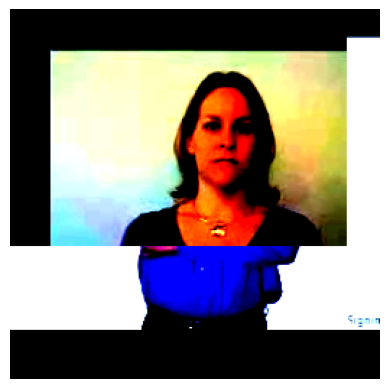

In [144]:
output_video(mixed_imgs, 0)

## Integration Test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])
torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


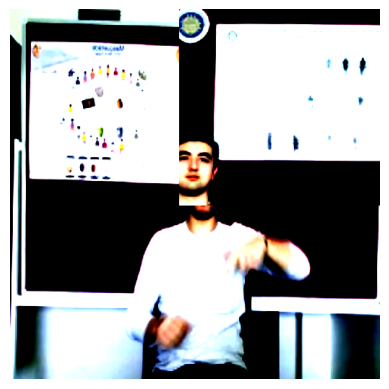

In [84]:
scrambmixv3 = Scrambmixv3(num_classes=226, num_frames=32)

mixed_imgs, mixed_label = scrambmixv3.do_blending(imgs, labels)
output_video(mixed_imgs)

## Scrambmix

In [ ]:
from mmaction.datasets import Scrambmix

In [ ]:
scrambmix = Scrambmix(num_classes=226, num_frames = 32, alpha=5)

In [ ]:
mixed_imgs, mixed_label = scrambmix.do_blending(imgs, labels)

In [ ]:
mixed_imgs.shape

In [ ]:
labels

In [ ]:
mixed_label

In [ ]:
mixed_imgs.shape

In [ ]:
output_video(imgs, 2)